In [65]:
import h5py
from glob import glob
import sys, scipy
import matplotlib as mpl
from scipy.stats import chi2
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle
#import gpustat
#gpustat.print_gpustat()
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # Some versions of HDF5 require this
os.environ['CUDA_VISIBLE_DEVICES']='2' # This is to choose which GPU to use

import sys
import tensorflow as tf

import keras
from keras import backend as K
#sys.setrecursionlimit(1500)

import h5py
import numpy as np

from torch.utils.data import Dataset, DataLoader # The model is in keras, but I use pytorch for data generator

In [2]:
INPUT_LENGTH = 10 # number of particles to consider in 1 event
BATCH_SIZE = 50

# this is the location on the caltech machine. Change it according to your case
# base_dir = '/bigdata/shared/TOPCLASS2018/BSMAnomaly_IsoLep_lt_45_pt_gt_23_NEW/SMmix_qcd_tt_w_z/' 
base_dir = 'testfiles'

# I made a copy of data to lxplus: /eos/project/d/dshep/BSM_Detection/THONG_TMP/SMmix_qcd_tt_w_z
# The particles in the event are currently sorted by pT

In [3]:
class SimpleEventSequence(Dataset):
    def __init__(self, data_x, data_y):
        self.len = data_x.shape[0]
        self.data_x = torch.from_numpy(data_x).float()
        self.data_y = torch.from_numpy(data_y)
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_x[idx], self.data_y[idx])

class EventSequence(Dataset):
    def check_data(self, file_names):
        num_data = 0
        thresholds = [0]
        for in_file_name in file_names:
            h5_file = h5py.File( in_file_name, 'r' )
            X = h5_file[self.feature_name]
            if hasattr(X, 'keys'):
                num_data += len(X[X.keys()[0]])
                thresholds.append(num_data)
            else:
                num_data += len(X)
                thresholds.append(num_data)
            h5_file.close()
        return (num_data, thresholds)

    def __init__(self, dir_name, feature_name = 'Particles', label_name = 'Labels', sequence_length=50, verbose=False):
        self.feature_name = feature_name
        self.label_name = label_name
        self.file_names = glob(dir_name+'/*.h5')
        self.num_data, self.thresholds = self.check_data(self.file_names)
        self.sequence_length = sequence_length
        self.file_index = 0
        self.h5_file = h5py.File(self.file_names[self.file_index],'r')
        self.get_data()
        self.verbose=verbose
        
    def get_data(self):
        self.X = np.array(self.h5_file.get(self.feature_name))[:,:self.sequence_length,4:7] # 4:7 is positions of pT, eta, phi
        self.Y = np.array(self.h5_file.get(self.label_name))
#         self.X[:,0] = self.X[:,0]/15.

    def is_numpy_array(self, data):
        return isinstance(data, np.ndarray)

    def get_num_samples(self, data):
        """Input: dataset consisting of a numpy array or list of numpy arrays.
            Output: number of samples in the dataset"""
        if self.is_numpy_array(data):
            return len(data)
        else:
            return len(data[0])

    def get_index(self, idx):
        """Translate the global index (idx) into local indexes,
        including file index and event index of that file"""
        file_index = next(i for i,v in enumerate(self.thresholds) if v > idx)
        file_index -= 1
        event_index = idx - self.thresholds[file_index]
        return file_index, event_index

    def get_thresholds(self):
        return self.thresholds

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        file_index, event_index = self.get_index(idx)
        
        if file_index != self.file_index:
            self.h5_file.close()
            self.file_index = file_index
            if self.verbose: 
                print("Opening new file {}".format(self.file_names[self.file_index]))
            self.h5_file = h5py.File(self.file_names[self.file_index],'r')
            self.get_data()
            self.X, self.Y = shuffle(self.X, self.Y)
        #return [self.X[event_index], np.argmax(self.Y[event_index])]
        return (self.X[event_index], self.X[event_index]) 


In [4]:
from keras.models import Model
from keras.layers import Input, GRU, LSTM, Dense, Reshape, Lambda, Concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

InputLayer = Input(shape=(INPUT_LENGTH,3))
enc = LSTM(30, activation='relu', recurrent_activation='hard_sigmoid')(InputLayer)
enc_output = Dense(3, activation='relu')(enc)

dec = Dense(30, activation='relu')(enc_output)
dec = Dense(INPUT_LENGTH, activation='relu')(dec)
dec = Reshape((INPUT_LENGTH,1))(dec)
dec_output_pt = LSTM(1, return_sequences=True)(dec)
dec_output_eta = LSTM(1, return_sequences=True)(dec)
dec_output_phi = LSTM(1, return_sequences=True)(dec)

dec_output = Concatenate(axis=2)([dec_output_pt, dec_output_eta, dec_output_phi])

####
model = Model(inputs=InputLayer, outputs=dec_output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 30)           4080        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            93          lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           120       

In [5]:

train_loader = DataLoader(EventSequence(dir_name=base_dir+'/train/',
                                    feature_name ='Particles', label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                                    batch_size = BATCH_SIZE, shuffle=False,num_workers=3)
    
val_loader = DataLoader(EventSequence(dir_name=base_dir+'/val/',
                        feature_name ='Particles',label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                        batch_size = BATCH_SIZE, shuffle=False,num_workers=3)

# Turn this data loader into a generator
def cycle(iterable):
    while True:
        for x in iterable:
            yield x
            
train_iter = iter(cycle(train_loader))
val_iter = iter(cycle(val_loader))

history = model.fit_generator(train_iter,
        steps_per_epoch=len(train_loader),
        epochs=10,
        validation_data=val_iter,
        validation_steps=len(val_loader),
        #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
        #TerminateOnNaN()]
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
76/76 [==============================] - 30s 389ms/step - loss: 73.2409 - val_loss: 72.5465
Epoch 2/10
76/76 [==============================] - 9s 118ms/step - loss: 72.8140 - val_loss: 72.0407
Epoch 3/10
76/76 [==============================] - 12s 164ms/step - loss: 72.2647 - val_loss: 71.4687
Epoch 4/10
76/76 [==============================] - 8s 109ms/step - loss: 71.7063 - val_loss: 70.9203
Epoch 5/10
76/76 [==============================] - 6s 81ms/step - loss: 71.1947 - val_loss: 70.5790
Epoch 6/10
76/76 [==============================] - 7s 89ms/step - loss: 70.9994 - val_loss: 70.4134
Epoch 7/10
76/76 [==============================] - 13s 177ms/step - loss: 70.8309 - val_loss: 70.2429
Epoch 8/10
76/76 [==============================] - 4s 50ms/step - loss: 70.6583 - val_loss: 70.0691
Epoch 9/10
76/76 [==============================] - 4s 55ms/step - loss: 70.4831 - val_loss: 69.8933
Epoch 10/10
76/76 [================

In [6]:
seven = h5py.File('testfiles/train/007.h5')

In [7]:
seven.keys()

<KeysViewHDF5 ['HLF', 'Labels', 'Particles']>

In [8]:
seven['Labels']

<HDF5 dataset "Labels": shape (2000, 4), type "<f8">

In [9]:
seven['HLF']

<HDF5 dataset "HLF": shape (2000, 23), type "<f8">

In [10]:
seven['Particles']

<HDF5 dataset "Particles": shape (2000, 1621, 19), type "<f8">

TypeError: 'History' object is not subscriptable

In [11]:
particles = seven['Particles']

In [12]:
particles[0]

array([[180.89924136,  27.65714083, -12.47828297, ...,   1.        ,
          0.        ,  -1.        ],
       [238.18243045,   5.62228421,  -0.59218124, ...,   0.        ,
          0.        ,   0.        ],
       [ 81.45895515,   5.46660966,  -0.24460271, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [13]:
particles.shape

(2000, 1621, 19)

In [14]:
input_particles = particles[:,:10,4:7]

In [32]:
output_particles = model.predict(particles[:,:10,4:7])

In [33]:
output_particles.shape

(2000, 10, 3)

In [34]:
print(output_particles[1])
print(input_particles[1])


[[ 0.22139776  0.00814797  0.06345177]
 [ 0.47608724  0.01776517  0.10770728]
 [ 0.69950175  0.02909195  0.13875198]
 [ 0.8434945   0.04239029  0.16075431]
 [ 0.99347556  0.         -0.        ]
 [ 0.99911433  0.         -0.        ]
 [ 0.9693472   0.00814797 -0.3117854 ]
 [ 0.9611392   0.01776517 -0.20604743]
 [ 0.95887285  0.02909195 -0.08685399]
 [ 0.99999815  0.         -0.        ]]
[[26.15293312  0.52625591 -2.8114171 ]
 [ 7.53312445 -0.09507351 -1.29941583]
 [ 4.9883728  -3.17619014  0.21815601]
 [ 4.92174721 -1.26040292  2.48516226]
 [ 4.9013114  -4.10924053 -0.91253793]
 [ 4.82679319  3.1482358  -2.46446586]
 [ 4.53369427 -2.4375596   1.6097182 ]
 [ 3.95847893  2.01046443 -2.3706758 ]
 [ 3.81762362  3.18231177  1.23325264]
 [ 3.79852557  0.88584149  0.18448886]]


(array([ 42.,  84., 100., 115., 131., 140., 140., 143., 143., 151., 132.,
        129., 118.,  70.,  43.,  45.,  31.,  30.,  30.,  21.,  23.,  11.,
         15.,  11.,   7.,   7.,   9.,  10.,   2.,   5.,   3.,   4.,   3.,
          2.,   0.,   1.,   1.,   3.,   1.,   4.,   4.,   0.,   3.,   1.,
          2.,   1.,   1.,   1.,   3.,   1.,   0.,   2.,   0.,   1.,   0.,
          1.,   0.,   2.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,   3.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([ 23.02119827,  24.51019741,  25.99919655,  27.48819569,
         28.97719482,  30.46619396,  31.9551931 ,  33.44419224,
         34.93319138,  36.42219051,  37.91118965,  39.40018879,
         40.88918793,  42.37818707,  43.8671862 ,  45.35618534,
         46.84518448,  48.33418362,  49.82318275,  51.31218189,

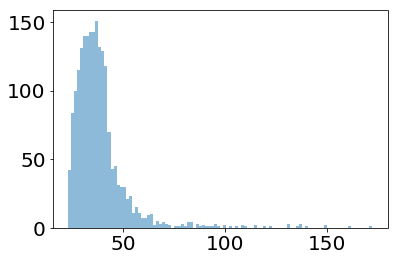

In [79]:
plt.figure()
maxpt_out = [max([part[0] for part in event]) for event in output_particles]
maxpt_in = [max([part[0] for part in event]) for event in input_particles]

#plt.hist([ptout * max(maxpt_in) for ptout in maxpt_out], alpha=0.5, bins=20)
plt.hist(maxpt_in, alpha=0.5, bins=100)
#plt.hist(maxpt_out)

In [72]:
mpl.rcParams.keys() 

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

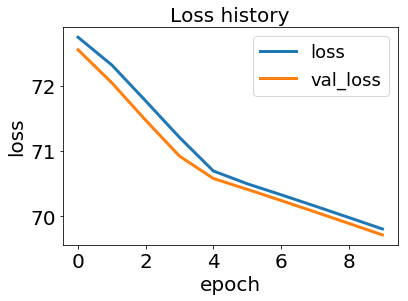

In [81]:
mpl.rc('lines', linewidth=3)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

mpl.rc('legend', fontsize=18)
mpl.rc('figure', titlesize=20)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)


plt.figure()
plt.title("Loss history")
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('hello.png', bbox_inches='tight')


In [ ]:
help(dec_output)

In [ ]:
dec_output.get_shape()

In [ ]:
dec_output[2].get_shape()

In [ ]:
dec_output[2][0].get_shape()

In [ ]:
dec_output[2][0][0].shape

In [ ]:
output_graph = dec_output.graph

In [ ]:
help(dec_output_pt)

In [ ]:
dec_output_pt.consumers()

In [ ]:
dec_output_pt.Print()

In [ ]:
model.predict(x_train)